<img style="float: left;" src="PSU_Logo.png" alt="UoE" width="200px"/>
<img style="float: right;" src="UoE_Logo.png" alt="UoE" width="300px"/>

# Sensitivity analysis with SimSphere
<img style="float: right;" src="LAI_Logo.png" alt="Land-Atmosphere Interactions" width="60px"/></p>
https://simsphere.ems.psu.edu/index.html  
Jupyter notebook for ECSC10014 Land-Atmosphere Interactions  
author: jbm *for* Session 2020-21  [version 0.14, latest 16:32, 9 Nov 2020]
## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *json* to read data files in json format
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *subprocess* so we can run the model written in FORTRAN

In [1]:
%matplotlib inline
# load pandas and json modules                                                                                               
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import subprocess

### Step 1: 
Now that we're familair with how to run the model let's run some 'what if' experiments to test how sensitive the model is to the variables driving land-atmosphere interactions.

In [2]:
# Run this cell ONCE when you load the notebook for the first time
# First, set some options to begin with here
outputvariables=['SWF','NETRAD','SENS','LE','GRF','T50','T10','TFOL','TRAD',
                 'W50','W10','WFOL','SH50','SH10','SHFOL','BOW','SMA','RZMA',
                 'STMR','VPDEF','LWPOT','EWPOT','GWPOT','CO2F','CO2CAN','WATEFF',
                 'O3CAN','GBLO3','O3F','PBLZ']
# As usual, make sure we bring in a fresh copy of the original state variables
# Edit this file in your workspace - DO NOT edit the original file.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory as a copy which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
# Read in the input data so we can modify the parameters
df = pd.read_json('i_model.json')
# run the model to check all is well and to set up some variables to help with later analysis
ret = subprocess.call(["./simsphere"],shell=True)
print("Run complete")
# Find the line number where the output data starts
lookup = 'TIME    SWF   NETRAD'   # the first line with column names
# Data analysis
with open('o_model.dat') as myFile:
    for num, line in enumerate(myFile, 1):
        if lookup in line:
            # print('Output starts at line:', num)
            stl = num

Run complete


You 'can' alter the input data manually as shown below - but I wouldn't recommend it! It is here as an example if you want to try though - otherwise you can run this cell and just move on!

In [3]:
# Lets check how to alter individual variables MANUALLY first:
# You can access individual elements of the input parameters
# by this convention: array[][][]
# so to see what is in the data array 'inputs' then 'soil' then 'fsub' for instance:
print(data['inputs']['soil']['fsub'])
# and you can then change it according to the same formula eg
data['inputs']['soil']['fsub'] = 0.1
print(data['inputs']['soil']['fsub'])
# put the whole new array back in the i_model.json file so we can re-run the model
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
# Have a look at the i_model.json file (use the File manager above) to check before re-running SimSphere
print(data['inputs']['soil']['fsub'])
# run the model again
ret = subprocess.call(["./simsphere"],shell=True)
print("Run complete")
# try this one more time just to show how it works:
data['inputs']['soil']['fsub'] = 0.3
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)

0.75
0.1
0.1
Run complete


It would be tedious to manually edit the input data in the way shown in the cell above. Luckily we can automate the sensitivity analysis using loops in python.  This is how we we will run the model from now on.  
What follows is several code blocks which are pretty much identical in format but which allow you to run a sensitivity analysis for 
 - Leaf area index
 - Soil Moisture
 - Surface Roughness
 - Soil Albedo
 - Vegetation Fraction

Your job is to choose ONE of these parameters and explore in detail how changing that parameter over its normal range affects some model output such a PBL depth, leaf temperature, soil moisture etc. You should be able to explain what the important processes are by making reference to the values of leaf temperatrure and sensible and latent heat fluxes in particular.  Ther are many experiments you can perform yourself and the SimSphere workbook is your friend here - it can help explain the processes involved. 

### Leaf Area Index
Change LAI in a systematic way

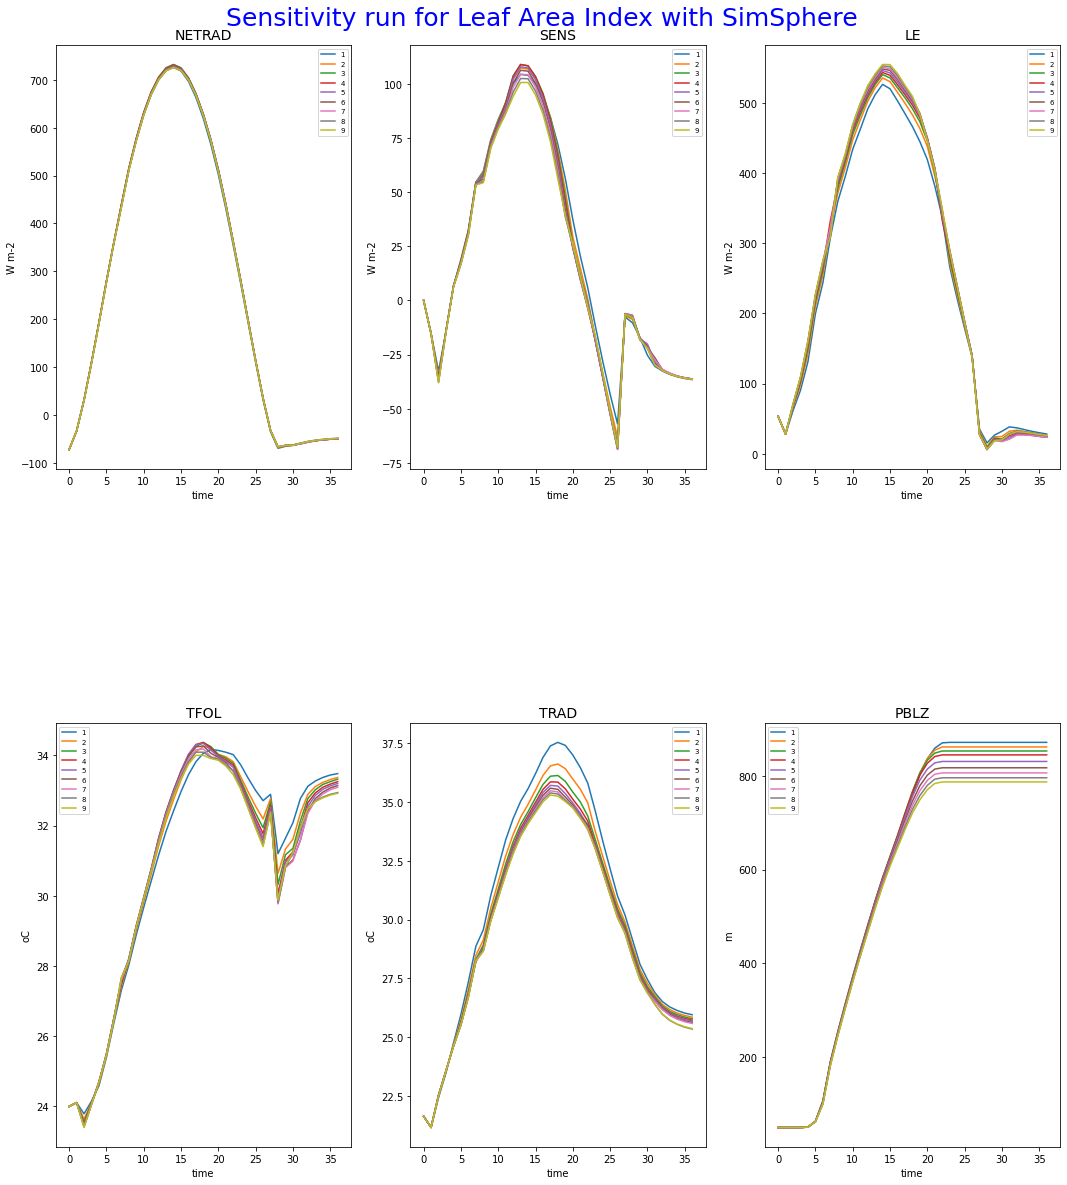

In [4]:
# We can automate the above and run the sensitivity experiment in a loop
# eg change the leaf area index (LAI) over a typical range
# each time running the model with a new value of xlai.
# Always re-load the original data (as a copy) so we are sure
# we are starting afresh in each experiment.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory as a copy which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
    
# Create a list of LAI values to use in the loop
listxlai = [1,2,3,4,5,6,7,8,9]
xcolumns = [str(x) for x in listxlai]
numruns=len(listxlai)

# First, create a set of dataframes to contain the output from each loop for each
# output variable - we'll then choose which ones to graph later.
d={}
for name in outputvariables:
    d[name] = pd.DataFrame()
    d[name].dropna(axis=1,inplace=True)   

for i in listxlai:
    # In this example, we change the leaf area index every loop
    data['inputs']['vegetation']['xlai'] = i
    # check progress
    # print(data['inputs']['vegetation']['xlai'])
    # put the new data into the input file to the model
    with open('i_model.json', 'w') as outfile:
        json.dump(data,outfile)
    # run the model
    ret = subprocess.call(["./simsphere"],shell=True)

    # Append relevant output data to a file for graphing once the test has finished
    # can now use Pandas to read in data since this part of the output file is a regular array
    df3=pd.read_csv('o_model.dat', sep='\s+',skiprows=stl-1, header=0, skip_blank_lines=True)
    df3.set_index('TIME')
    for j in outputvariables:
        l=df3[j].tolist()
        d[j][i]=l

#outputvariablestoplot=['NETRAD','SENS','LE','GRF','T10','TFOL','TRAD',
#                 'WFOL','SH10','SHFOL','BOW','SMA','RZMA',
#                 'STMR','VPDEF','CO2F','CO2CAN','WATEFF','PBLZ']
# Better to get the units from the program output - so write the code
#yunitstoplot = ['W m-2','W m-2','W m-2','W m-2','oC','oC','oC',
#                'kts','g kg-1','g kg-1', '', '', '',
#               's m-1', 'mbar', 'micromoles m-2 s-1', 'ppm', '', 'm']
# If you don't need or want to plot ALL the variables, just create a new list
# and define which output variables you want to plot eg
# just plot net radiation, sensible and latent heat, foliage and radiative temperature and PBL height - so
outputvariablestoplot = ['NETRAD','SENS','LE','TFOL','TRAD','PBLZ']
# and then make sure you've got a new list with the correct y-units to plot
yunitstoplot=['W m-2','W m-2','W m-2','oC','oC','m']
# and then comment out the original lists above and uncomment the two lines with with your own ones
# Define the grid of plots to make based on the number of plots selected
# 3 columns should make it easy on the eye
# check first - is the number of plots divisible by three - if not, note there's an extra row to plot
extrarow = len(outputvariablestoplot) % 3   # 3 columns
nrtp = int(len(outputvariablestoplot)/3)
if extrarow != 0:
    nrtp+=1

fig, axes = plt.subplots(nrtp, 3, figsize=(18,18))
#fig.tight_layout()    # create spaces between the plots
fig.suptitle('Sensitivity run for Leaf Area Index with SimSphere', fontsize=25, color='blue')
plt.subplots_adjust(
    left = 0.125,  # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.95,     # the top of the subplots of the figure
    wspace = 0.2,  # the amount of width reserved for space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.6   # the amount of height reserved for space between subplots,
)                  # expressed as a fraction of the average axis height
plt.rc('legend',fontsize=7) # using a size in points
i=0
row=0
while i <len(outputvariablestoplot):
    for i in range(len(outputvariablestoplot)):
        # What position to plot this in?
        r = int(i/3); c = i % 3
        d[outputvariablestoplot[i]].plot(ax=axes[r,c])
        axes[r,c].set_xlabel("time")
        axes[r,c].set_ylabel(yunitstoplot[i])
        axes[r,c].set_title(outputvariablestoplot[i], fontsize=14, color='black')
        i+=1
    
plt.show()
# Give it a few seconds to complete plotting

# If you want to look at the actual data then un-comment the following two lines (ie remove the '#' at the start)
#df4 = df3[['TIME','SWF','NETRAD','SENS','LE','GRF','T10','TFOL','SMA','STMR','VPDEF','PBLZ']]
#df4.head(36)

## Soil moisture

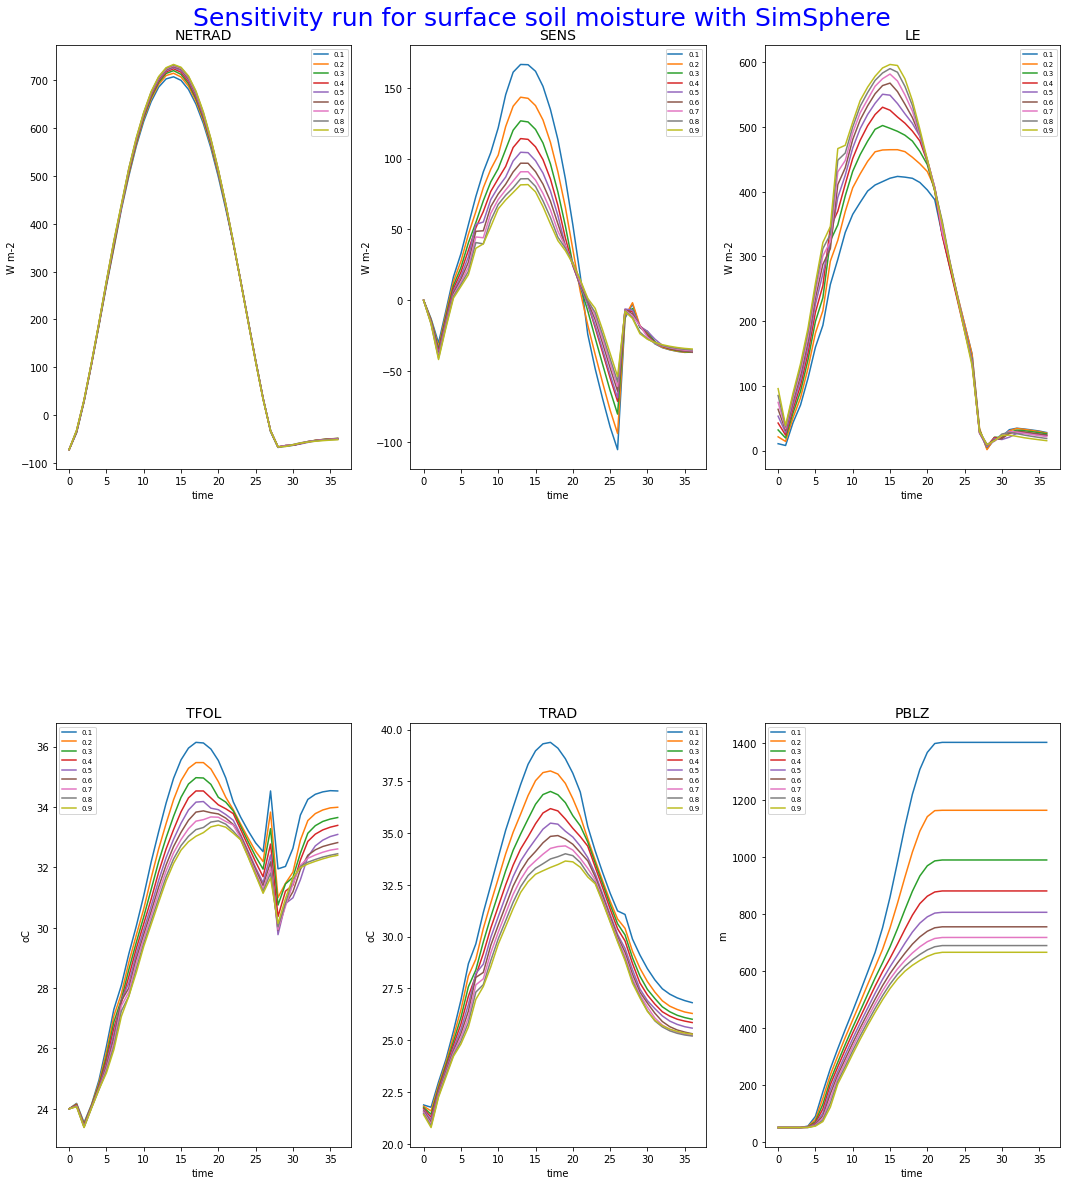

In [5]:
# We can automate the above and run the sensitivity experiment in a loop
# eg change the Surface Soil moisture (f) over a typical range
# each time running the model with a new value of sma.

# Always re-load the original data (as a copy) so we are sure
# we are starting afresh in each experiment.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory as a copy which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
  
# Create a list of SMA values to use in the loop
# use the Excel spreadsheet to get realsitic limit values
listxf = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
xcolumns = [str(x) for x in listxf]
xcolumns = ['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9']
numruns=len(listxf)

# First, create a set of dataframes to contain the output from each loop for each
# output variable - we'll then choose which ones to graph later.
d={}
for name in outputvariables:
    d[name] = pd.DataFrame()
    d[name].dropna(axis=1,inplace=True)   

for i in listxf:
    # In this example, we change the leaf area index every loop
    data['inputs']['soil']['f'] = i
    # check progress
    #print(data['inputs']['soil']['f'])
    # put the new data into the input file to the model
    with open('i_model.json', 'w') as outfile:
        json.dump(data,outfile)
    # run the model
    ret = subprocess.call(["./simsphere"],shell=True)
    
    # Append relevant output data to a file for graphing once the test has finished
    # can now use Pandas to read in data since this part of the output file is a regular array
    df3=pd.read_csv('o_model.dat', sep='\s+',skiprows=stl-1, header=0, skip_blank_lines=True)
    df3.set_index('TIME')
    for j in outputvariables:
        l=df3[j].tolist()
        d[j][i]=l

#outputvariablestoplot=['NETRAD','SENS','LE','GRF','T10','TFOL','TRAD',
#                 'WFOL','SH10','SHFOL','BOW','SMA','RZMA',
#                 'STMR','VPDEF','CO2F','CO2CAN','WATEFF','PBLZ']
# Better to get the units from the program output - so write the code
#yunitstoplot = ['W m-2','W m-2','W m-2','W m-2','oC','oC','oC',
#                'kts','g kg-1','g kg-1', '', '', '',
#               's m-1', 'mbar', 'micromoles m-2 s-1', 'ppm', '', 'm']
# If you don't need or want to plot ALL the variables, just create a new list
# and define which output variables you want to plot eg
# just plot net radiation, sensible and latent heat, foliage and radiative temperature and PBL height - so
outputvariablestoplot = ['NETRAD','SENS','LE','TFOL','TRAD','PBLZ']
# and then make sure you've got a new list with the correct y-units to plot
yunitstoplot=['W m-2','W m-2','W m-2','oC','oC','m']
# and then comment out the original lists above and uncomment the two lines with with your own ones
# Define the grid of plots to make based on the number of plots selected
# 3 columns should make it easy on the eye
# check first - is the number of plots divisible by three - if not, note there's an extra row to plot
extrarow = len(outputvariablestoplot) % 3   # 3 columns
nrtp = int(len(outputvariablestoplot)/3)
if extrarow != 0:
    nrtp+=1

fig, axes = plt.subplots(nrtp, 3, figsize=(18,18))
#fig.tight_layout()    # create spaces between the plots
fig.suptitle('Sensitivity run for surface soil moisture with SimSphere', fontsize=25, color='blue')
plt.subplots_adjust(
    left = 0.125,  # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.95,     # the top of the subplots of the figure
    wspace = 0.2,  # the amount of width reserved for space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.6   # the amount of height reserved for space between subplots,
)                  # expressed as a fraction of the average axis height
plt.rc('legend',fontsize=7) # using a size in points
i=0
while i <len(outputvariablestoplot):
    for i in range(len(outputvariablestoplot)):
        # What position to plot this in?
        r = int(i/3); c = i % 3
        d[outputvariablestoplot[i]].plot(ax=axes[r,c])
        axes[r,c].set_xlabel("time")
        axes[r,c].set_ylabel(yunitstoplot[i])
        axes[r,c].set_title(outputvariablestoplot[i], fontsize=14, color='black')
        i+=1
    
plt.show()
# Give it a few seconds to complete plotting

# If you want to look at the actual data then un-comment the following two lines (ie remove the '#' at the start)
#df4 = df3[['TIME','SWF','NETRAD','SENS','LE','GRF','T10','TFOL','SMA','STMR','VPDEF','PBLZ']]
#df4.head(36)

## Surface roughness

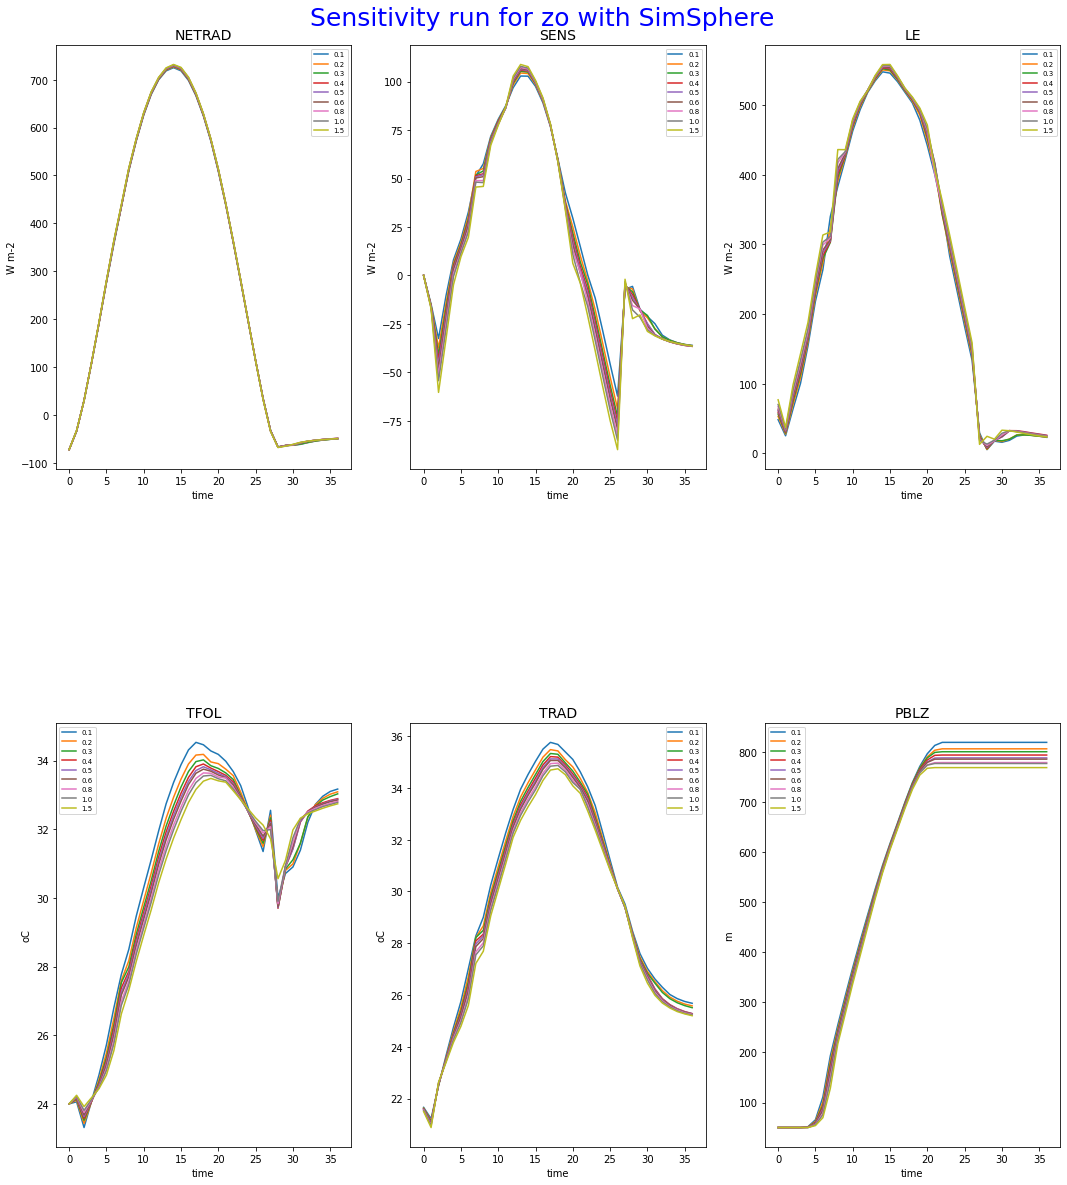

In [6]:
# We can automate the above and run the sensitivity experiment in a loop
# eg change the roughness length (zo) over a typical range
# each time running the model with a new value of sma.

# Always re-load the original data (as a copy) so we are sure
# we are starting afresh in each experiment.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory as a copy which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
  
# Create a list of zo values to use in the loop
# use the Excel spreadsheet to get realistic limit values
listxzo = [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0,1.5]
xcolumns = [str(x) for x in listxzo]
numruns=len(listxzo)

# First, create a set of dataframes to contain the output from each loop for each
# output variable - we'll then choose which ones to graph later.
d={}
for name in outputvariables:
    d[name] = pd.DataFrame()
    d[name].dropna(axis=1,inplace=True)   

for i in listxzo:
    # In this example, we change the leaf area index every loop
    data['inputs']['meteorological']['zo'] = i
    # check progress
    #print(data['inputs']['meteorological']['zo'])
    # put the new data into the input file to the model
    with open('i_model.json', 'w') as outfile:
        json.dump(data,outfile)
    # run the model
    ret = subprocess.call(["./simsphere"],shell=True)
    # print("Model loop complete")
    # Append relevant output data to a file for graphing once the test has finished
    # can now use Pandas to read in data since this part of the output file is a regular array
    df3=pd.read_csv('o_model.dat', sep='\s+',skiprows=stl-1, header=0, skip_blank_lines=True)
    df3.set_index('TIME')
    for j in outputvariables:
        l=df3[j].tolist()
        d[j][i]=l

#outputvariablestoplot=['NETRAD','SENS','LE','GRF','T10','TFOL','TRAD',
#                 'WFOL','SH10','SHFOL','BOW','SMA','RZMA',
#                 'STMR','VPDEF','CO2F','CO2CAN','WATEFF','PBLZ']
# Better to get the units from the program output - so write the code
#yunitstoplot = ['W m-2','W m-2','W m-2','W m-2','oC','oC','oC',
#                'kts','g kg-1','g kg-1', '', '', '',
#               's m-1', 'mbar', 'micromoles m-2 s-1', 'ppm', '', 'm']
# If you don't need or want to plot ALL the variables, just create a new list
# and define which output variables you want to plot eg
# just plot net radiation, sensible and latent heat, foliage and radiative temperature and PBL height - so
outputvariablestoplot = ['NETRAD','SENS','LE','TFOL','TRAD','PBLZ']
# and then make sure you've got a new list with the correct y-units to plot
yunitstoplot=['W m-2','W m-2','W m-2','oC','oC','m']
# and then comment out the original lists above and uncomment the two lines with with your own ones
# Define the grid of plots to make based on the number of plots selected
# 3 columns should make it easy on the eye
# check first - is the number of plots divisible by three - if not, note there's an extra row to plot
extrarow = len(outputvariablestoplot) % 3   # 3 columns
nrtp = int(len(outputvariablestoplot)/3)
if extrarow != 0:
    nrtp+=1

fig, axes = plt.subplots(nrtp, 3, figsize=(18,18))
#fig.tight_layout()    # create spaces between the plots
fig.suptitle('Sensitivity run for zo with SimSphere', fontsize=25, color='blue')
plt.subplots_adjust(
    left = 0.125,  # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.95,     # the top of the subplots of the figure
    wspace = 0.2,  # the amount of width reserved for space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.6   # the amount of height reserved for space between subplots,
)                  # expressed as a fraction of the average axis height
plt.rc('legend',fontsize=7) # using a size in points
i=0
while i <len(outputvariablestoplot):
    for i in range(len(outputvariablestoplot)):
        # What position to plot this in?
        r = int(i/3); c = i % 3
        d[outputvariablestoplot[i]].plot(ax=axes[r,c])
        axes[r,c].set_xlabel("time")
        axes[r,c].set_ylabel(yunitstoplot[i])
        axes[r,c].set_title(outputvariablestoplot[i], fontsize=14, color='black')
        i+=1
    
plt.show()
# Give it a few seconds to complete plotting

# If you want to look at the actual data then un-comment the following two lines (ie remove the '#' at the start)
#df4 = df3[['TIME','SWF','NETRAD','SENS','LE','GRF','T10','TFOL','SMA','STMR','VPDEF','PBLZ']]
#df4.head(36)

## Soil Alebedo

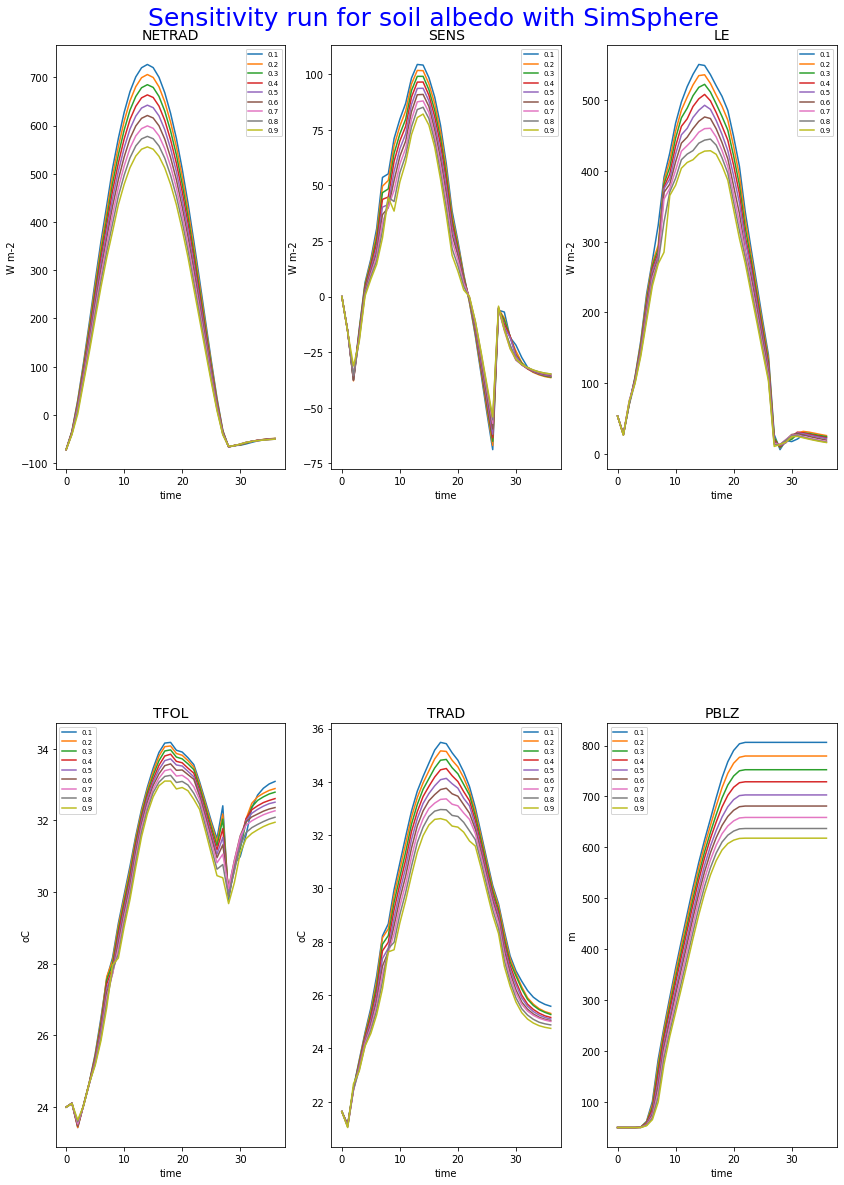

In [7]:
# We can automate the above and run the sensitivity experiment in a loop
# eg change the soil albedo (albg) over a typical range
# each time running the model with a new value of xlai.
# Always re-load the original data (as a copy) so we are sure
# we are starting afresh in each experiment.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory as a copy which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
    
# If you're running this in Jupyter Lab you should be open the file
# named i_model.json and see the names of variables in each of the 
# main groups such as 'soil', 'meteorological' etc.

# Create a list of soil albedo values to use in the loop
listxalbg = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
xcolumns = [str(x) for x in listxalbg]
numruns=len(listxalbg)

# First, create a set of dataframes to contain the output from each loop for each
# output variable - we'll then choose which ones to graph later.
d={}
for name in outputvariables:
    d[name] = pd.DataFrame()
    d[name].dropna(axis=1,inplace=True)   

for i in listxalbg:
    # In this example, we change the soil albedo every loop
    data['inputs']['soil']['albg'] = i
    # check progress
    # print(data['inputs']['soil']['albg'])
    # put the new data into the input file to the model
    with open('i_model.json', 'w') as outfile:
        json.dump(data,outfile)
    # run the model
    ret = subprocess.call(["./simsphere"],shell=True)
    # print("Model loop complete")
    # Append relevant output data to a file for graphing once the test has finished
    # can now use Pandas to read in data since this part of the output file is a regular array
    df3=pd.read_csv('o_model.dat', sep='\s+',skiprows=stl-1, header=0, skip_blank_lines=True)
    df3.set_index('TIME')
    for j in outputvariables:
        l=df3[j].tolist()
        d[j][i]=l

#outputvariablestoplot=['NETRAD','SENS','LE','GRF','T10','TFOL','TRAD',
#                 'WFOL','SH10','SHFOL','BOW','SMA','RZMA',
#                 'STMR','VPDEF','CO2F','CO2CAN','WATEFF','PBLZ']
# Better to get the units from the program output - so write the code
#yunitstoplot = ['W m-2','W m-2','W m-2','W m-2','oC','oC','oC',
#                'kts','g kg-1','g kg-1', '', '', '',
#               's m-1', 'mbar', 'micromoles m-2 s-1', 'ppm', '', 'm']
# If you don't need or want to plot ALL the variables, just create a new list
# and define which output variables you want to plot eg
# just plot net radiation, sensible and latent heat, foliage and radiative temperature and PBL height - so
outputvariablestoplot = ['NETRAD','SENS','LE','TFOL','TRAD','PBLZ']
# and then make sure you've got a new list with the correct y-units to plot
yunitstoplot=['W m-2','W m-2','W m-2','oC','oC','m']
# and then comment out the original lists above and uncomment the two lines with with your own ones
# Define the grid of plots to make based on the number of plots selected
# 3 columns should make it easy on the eye
# check first - is the number of plots divisible by three - if not, note there's an extra row to plot
extrarow = len(outputvariablestoplot) % 3   # 3 columns
nrtp = int(len(outputvariablestoplot)/3)
if extrarow != 0:
    nrtp+=1
# print(nrtp)

fig, axes = plt.subplots(nrtp, 3, figsize=(14,18))
#fig.tight_layout()    # create spaces between the plots
fig.suptitle('Sensitivity run for soil albedo with SimSphere', fontsize=25, color='blue')
plt.subplots_adjust(
    left = 0.125,  # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.95,     # the top of the subplots of the figure
    wspace = 0.2,  # the amount of width reserved for space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.6   # the amount of height reserved for space between subplots,
)                  # expressed as a fraction of the average axis height
plt.rc('legend',fontsize=7) # using a size in points
i=0
while i <len(outputvariablestoplot):
    for i in range(len(outputvariablestoplot)):
        # What position to plot this in?
        r = int(i/3); c = i % 3
        d[outputvariablestoplot[i]].plot(ax=axes[r,c])
        axes[r,c].set_xlabel("time")
        axes[r,c].set_ylabel(yunitstoplot[i])
        axes[r,c].set_title(outputvariablestoplot[i], fontsize=14, color='black')
        i+=1
    
plt.show()
# Give it a few seconds to complete plotting

# If you want to look at the actual data then un-comment the following two lines (ie remove the '#' at the start)
#df4 = df3[['TIME','SWF','NETRAD','SENS','LE','GRF','T10','TFOL','SMA','STMR','VPDEF','PBLZ']]
#df4.head(36)

## Vegetation fraction

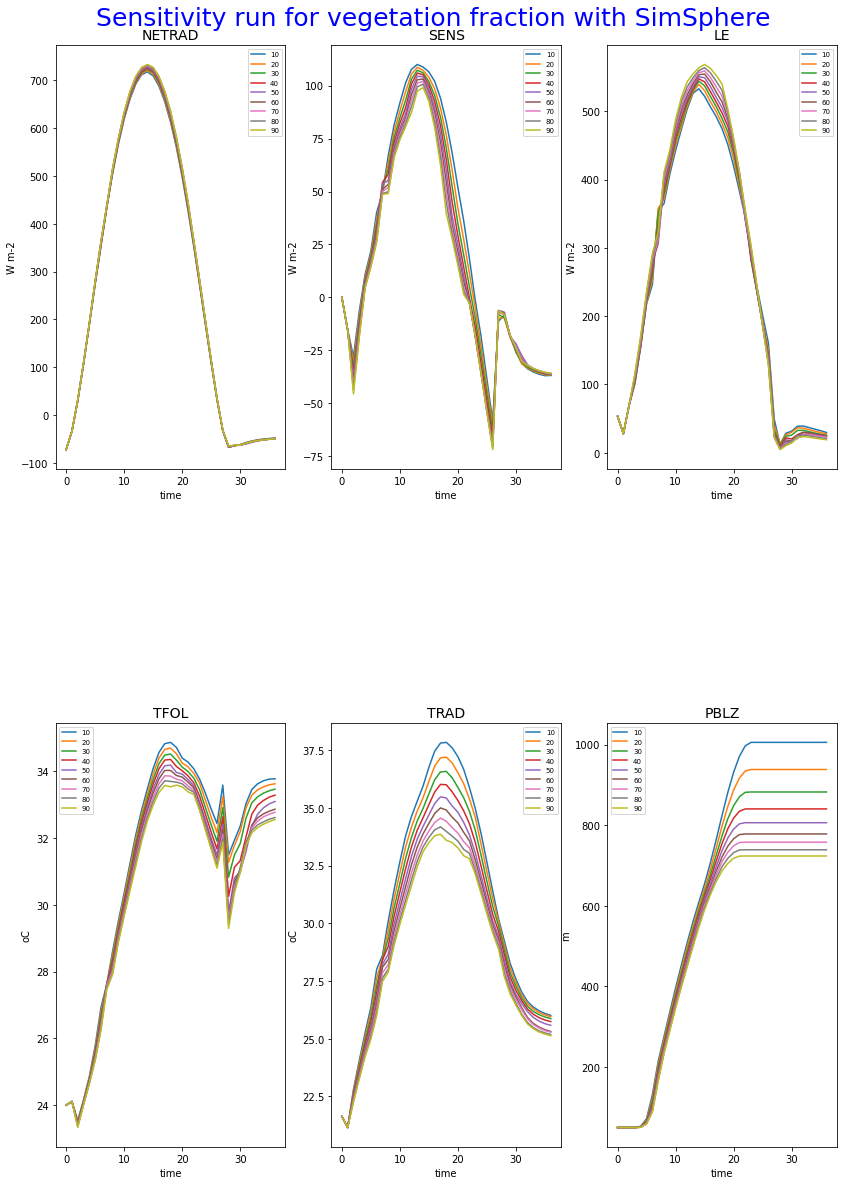

In [8]:
# We can automate the above and run the sensitivity experiment in a loop
# eg change the vegetation fraction (frveg) over a typical range
# each time running the model with a new value of frveg.

# Always re-load the original data (as a copy) so we are sure
# we are starting afresh in each experiment.
with open('data/default/i_model.json') as json_file:
    data = json.load(json_file)
# and put a copy in the current working directory and which can then be edited
with open('i_model.json', 'w') as outfile:
    json.dump(data,outfile)
    
# If you're running this in Jupyter Lab you should be able to open the file
# named i_model.json and see the names of variables in each of the 
# main groups such as 'soil', 'meteorological' etc.

# Create a list of vegetation fraction cover values to use in the loop
listxfrveg = [10,20,30,40,50,60,70,80,90]
xcolumns = [str(x) for x in listxfrveg]
numruns=len(listxfrveg)

# First, create a set of dataframes to contain the output from each loop for each
# output variable - we'll then choose which ones to graph later.
d={}
for name in outputvariables:
    d[name] = pd.DataFrame()
    d[name].dropna(axis=1,inplace=True)   

for i in listxfrveg:
    # In this example, we change the fraction of the ground covered by veg every loop
    data['inputs']['vegetation']['frveg'] = i
    # check progress
    # print(data['inputs']['soil']['albg'])
    # put the new data into the input file to the model
    with open('i_model.json', 'w') as outfile:
        json.dump(data,outfile)
    # run the model
    ret = subprocess.call(["./simsphere"],shell=True)
    # print("Model loop complete")
    # Append relevant output data to a file for graphing once the test has finished
    # can now use Pandas to read in data since this part of the output file is a regular array
    df3=pd.read_csv('o_model.dat', sep='\s+',skiprows=stl-1, header=0, skip_blank_lines=True)
    df3.set_index('TIME')
    for j in outputvariables:
        l=df3[j].tolist()
        d[j][i]=l

#outputvariablestoplot=['NETRAD','SENS','LE','GRF','T10','TFOL','TRAD',
#                 'WFOL','SH10','SHFOL','BOW','SMA','RZMA',
#                 'STMR','VPDEF','CO2F','CO2CAN','WATEFF','PBLZ']
# Better to get the units from the program output - so write the code
#yunitstoplot = ['W m-2','W m-2','W m-2','W m-2','oC','oC','oC',
#                'kts','g kg-1','g kg-1', '', '', '',
#               's m-1', 'mbar', 'micromoles m-2 s-1', 'ppm', '', 'm']
# If you don't need or want to plot ALL the variables, just create a new list
# and define which output variables you want to plot eg
# just plot net radiation, sensible and latent heat, foliage and radiative temperature and PBL height - so
outputvariablestoplot = ['NETRAD','SENS','LE','TFOL','TRAD','PBLZ']
# and then make sure you've got a new list with the correct y-units to plot
yunitstoplot=['W m-2','W m-2','W m-2','oC','oC','m']
# and then comment out the original lists above and uncomment the two lines with with your own ones
# Define the grid of plots to make based on the number of plots selected
# 3 columns should make it easy on the eye
# check first - is the number of plots divisible by three - if not, note there's an extra row to plot
extrarow = len(outputvariablestoplot) % 3   # 3 columns
nrtp = int(len(outputvariablestoplot)/3)
if extrarow != 0:
    nrtp+=1
# print(nrtp)

fig, axes = plt.subplots(nrtp, 3, figsize=(14,18))
#fig.tight_layout()    # create spaces between the plots
fig.suptitle('Sensitivity run for vegetation fraction with SimSphere', fontsize=25, color='blue')
plt.subplots_adjust(
    left = 0.125,  # the left side of the subplots of the figure
    right = 0.9,   # the right side of the subplots of the figure
    bottom = 0.1,  # the bottom of the subplots of the figure
    top = 0.95,     # the top of the subplots of the figure
    wspace = 0.2,  # the amount of width reserved for space between subplots,
                   # expressed as a fraction of the average axis width
    hspace = 0.6   # the amount of height reserved for space between subplots,
)                  # expressed as a fraction of the average axis height
plt.rc('legend',fontsize=7) # using a size in points             
i=0
while i <len(outputvariablestoplot):
    for i in range(len(outputvariablestoplot)):
        # What position to plot this in?
        r = int(i/3); c = i % 3
        d[outputvariablestoplot[i]].plot(ax=axes[r,c])
        axes[r,c].set_xlabel("time")
        axes[r,c].set_ylabel(yunitstoplot[i])
        axes[r,c].set_title(outputvariablestoplot[i], fontsize=14, color='black')
        i+=1
    
plt.show()
# Give it a few seconds to complete plotting

# If you want to look at the actual data then un-comment the following two lines (ie remove the '#' at the start)
#df4 = df3[['TIME','SWF','NETRAD','SENS','LE','GRF','T10','TFOL','SMA','STMR','VPDEF','PBLZ']]
#df4.head(36)

## Are you ready to try your own? 
Try amending the cell above ie use it as a template for your own runs.  Doesn't matter if not - I'm NOT trying to turn you into a python programmer. There's plenty to talk about with ANY ONE of the simulations above.

## End of Simulations

## ------------------------------------------------------------------------

## Have a look at the XLS if you don't have Excel to hand

In [24]:
inputparams_df = pd.read_excel("./Part IV; model input parameters.xlsx", 'input variables', skiprows=1,nrows=51)
#inpars = inputparams_df.to_dict("records")
inputparams_df

,Category,Name,Long Name,default value,data type,Units,lower,upper
0,Meteorological,omega,Atmospheric Precipitable Water,3.13,float,cm,0.05,5
1,Meteorological,zo,Surface Roughness,0.2,float,meters,0.01,2
2,Meteorological,obst_hgt,Obstacle Height,1,float,meters,0.01,2
3,Meteorological,cloud_flag,Cloud Cover,F,char,NaN,"{T,F}",NaN
4,Meteorological,cld_fract,Cloud Cover Fraction,0,int,perdecage?,1,10
5,NaN,nobs_ptq,Number of Humidity Observations,12,int,NaN,3,50
6,NaN,nobs_wind,Number of Wind Observations,11,int,NaN,3,50
7,Soil,f,Surface Moisture,0.5,float,NaN,0,1
8,Soil,fsub,Root Zone Moisture,0.75,float,NaN,0,1
9,Soil,wmax,Substrate Maximum Water,0.34,float,NaN,0,1


In [ ]:
'''
TIME: Local time (hours)
 SWF: Shortwave_Flux (W m-2)
 NETRAD: Net_Radiation (W m-2)
 SENS: Sensible_Heat_Flux (W m-2)
 LE: Latent_Heat_Flux (W m-2)
 GRF: Ground_Flux (W m-2)
 T50: Air_Temperature_50m (C)
 T10: Air_Temperature_10m (C)
 TFOL: Air_Temperature_Foliage (C)
 TRAD: Radiometric_Temperature (C)
 W50: Wind_50_Meters (Kts)
 W10: Wind_10_Meters (Kts)
 WFOL: Wind_In_Foliage (Kts)
 SH50: Specific_Humidity_50m (g Kg-1)
 SH10: Specific_Humidity_10m (g Kg-1)
 SHFOL: Specific_Humidity_In_Foliage (g Kg-1)
 BOW: Bowen_Ratio
 SMA: Surface_Moisture_Availability
 RZMA: Root_Zone_Moisture_Availability
 STMR: Stomatal_Resistance (s m-1)
 VPDEF: Vapour_Pressure_Deficit (mbar)
 LWPOT: Leaf_Water_Potential (bars)
 EWPOT: Epidermal_Water_Potential (bars)
 GWPOT: Ground_Water_Potential (bars)
 CO2F: CO2_Flux (micromoles m-2 s-1)
 CO2CAN: CO2_Concentration_Canopy (ppmv)
 WATEFF: Water_Use_Efficiency
 O3CAN: O3_conc_canopy (ppmv)
 GBLO3: Global_O3_flux (ug m-2 s-1)
 O3F: O3_flux_plant (ug m-2 s-1)
 PBLZ: Planetary Boundary Layer depth (m)
 
 
 '''